In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

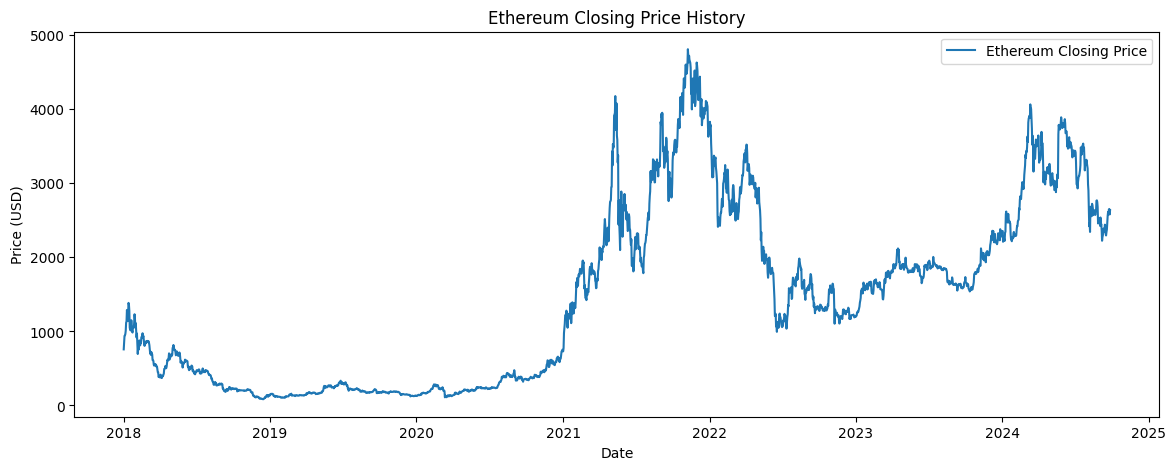

In [ ]:
# 1. Loading and Inspecting the Data
data = pd.read_csv('/content/sample_data/ethereum_daily_data_2018_2024.csv')

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])

# Set 'time' as index
data.set_index('time', inplace=True)

# Visualizing the Ethereum closing price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Ethereum Closing Price')
plt.title('Ethereum Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# 2. Data Preprocessing

# Scale the 'Close' prices for LSTM input (range 0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Creating a function to split the data into sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

# Define the sequence length (e.g., 60 days)
sequence_length = 60

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create training sequences and labels
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)



In [ ]:
# Building the LSTM Model

# Initialize the LSTM model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(Input(shape=(X_train.shape[1], 1)))  # Defining the input shape explicitly
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layers for output
model.add(Dense(units=25))
model.add(Dense(units=1))  # Final output layer

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (70 epochs, batch size of 84)
history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0416 - val_loss: 0.0019
Epoch 2/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 3/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 4/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 6/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 7/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 8/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 10/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 11/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0

In [ ]:
# 6. Model Evaluation

# Predicting on the test data
predictions = model.predict(X_test)

# Inverse scaling the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Inverse scaling the actual test values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error: {mse}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Squared Error: 13766.029083924643


In [ ]:
# 7. Predicting Future Ethereum Price

# Get the last 60 days of data from the dataset
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)

# Scale the last 60 days data
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to hold the scaled sequence
X_predict = []
X_predict.append(last_60_days_scaled)

# Convert the list to a numpy array and reshape for LSTM input
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Predict the future price
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Ethereum Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Ethereum Price: 2698.26171875


In [ ]:
# Create a DataFrame for results
results_df = pd.DataFrame({
    'Metric': ['Total Data Points', 'Training Data Points', 'Testing Data Points',
               'Mean Squared Error (MSE)', 'First Actual Price', 'First Predicted Price',
               'Last Actual Price', 'Last Predicted Price', 'Predicted Future Price'],
    'Value': [len(data), len(X_train), len(X_test),
              mse, y_test_scaled[0][0], predictions[0][0],
              y_test_scaled[-1][0], predictions[-1][0], predicted_price[0][0]]
})

# Markdown
print(results_df.to_markdown())

|    | Metric                   |    Value |
|---:|:-------------------------|---------:|
|  0 | Total Data Points        |  2462    |
|  1 | Training Data Points     |  1909    |
|  2 | Testing Data Points      |   433    |
|  3 | Mean Squared Error (MSE) | 13766    |
|  4 | First Actual Price       |  1866.58 |
|  5 | First Predicted Price    |  1943.87 |
|  6 | Last Actual Price        |  2636.51 |
|  7 | Last Predicted Price     |  2705.15 |
|  8 | Predicted Future Price   |  2698.26 |


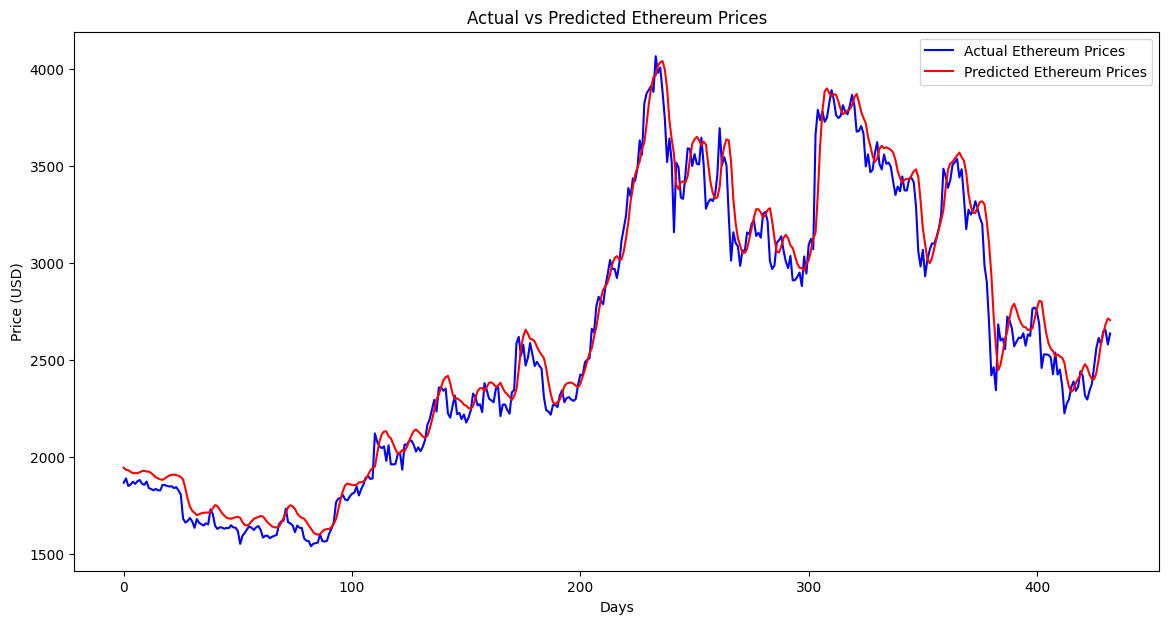

In [ ]:
# Plotting actual vs predicted prices

plt.figure(figsize=(14, 7))

# actual
plt.plot(y_test_scaled, label='Actual Ethereum Prices', color='blue')

# predicted prices
plt.plot(predictions, label='Predicted Ethereum Prices', color='red')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()


plt.show()

In [ ]:
# Predicting Future Prices for the Next 60 Days

# Number of days to predict into the future
future_days = 60

# Get the last 60 days of data for starting the predictions
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_60_days_scaled = scaler.transform(last_60_days)

# List to store the predicted future prices
future_predictions = []

# Loop to predict the next 60 days
for i in range(future_days):
    # Create a new sequence from the last 60 days
    X_predict = []
    X_predict.append(last_60_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    # Predict the price for the next day
    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    # Store the predicted price
    future_predictions.append(predicted_price_unscaled[0, 0])

    # Update the sequence to include the predicted price
    new_scaled_data = np.append(last_60_days_scaled[1:], predicted_price, axis=0)
    last_60_days_scaled = new_scaled_data.reshape(-1, 1)

# َAdd to plott

future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

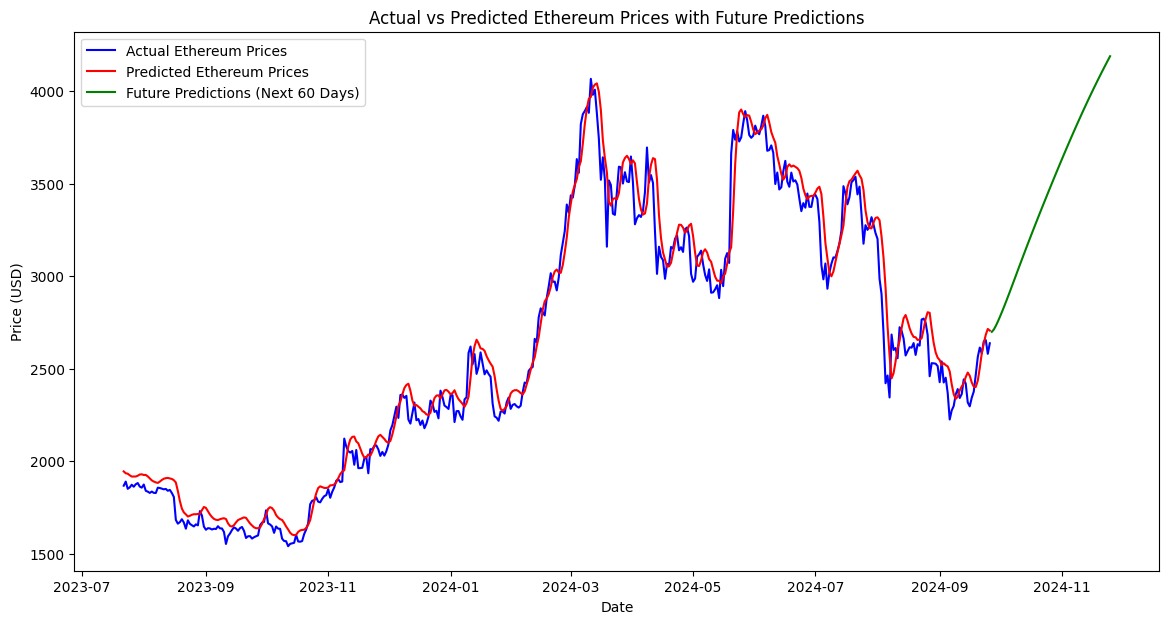

In [ ]:
# Plotting future predictions alongside actual prices

plt.figure(figsize=(14, 7))

# actual prices
plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Ethereum Prices', color='blue')

# predictions price
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Predicted Ethereum Prices', color='red')

# Future Predictions (Next 60 Days)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 60 Days)', color='green')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()


plt.show()

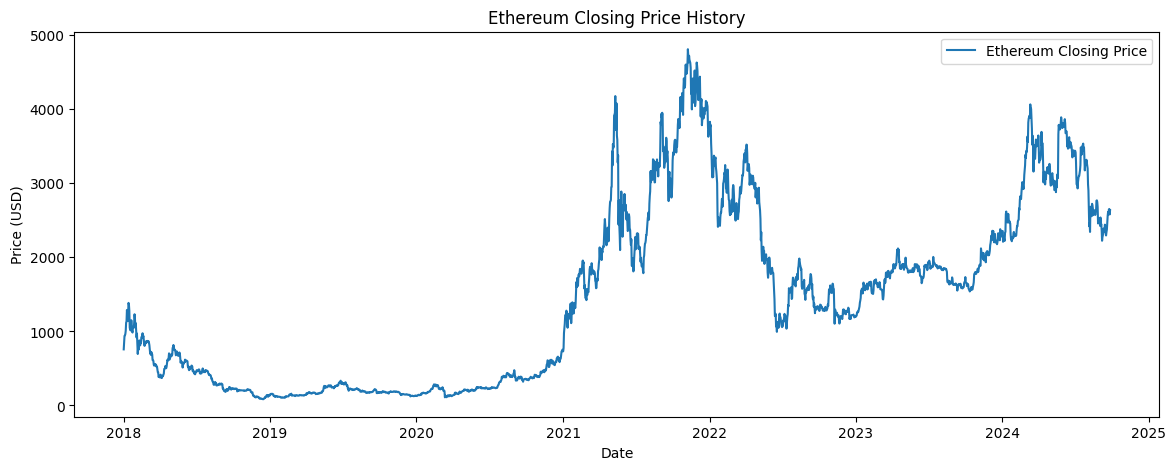

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
   units  dropout  dense_units activation  learning_rate  epochs  batch_size  \
0     50      0.2           25       relu         0.0010      50          64   
1     64      0.3           32       tanh         0.0020     100          32   
2    128      0.1           50       relu         0.0005      70         128   

  optimizer     initializer  validation_loss  mean_squared_error  
0      adam  glorot_uniform         0.000594        14301.075945  
1      adam       he_normal         0.000351        10321.265888  
2   rmsprop       he_normal         0.000637        86672.499941  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error
from tensorflow.keras.initializers import HeNormal, GlorotUniform

# 1. Loading and Inspecting the Data
data = pd.read_csv('/content/sample_data/ethereum_daily_data_2018_2024.csv')

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])

# Set 'time' as index
data.set_index('time', inplace=True)

# Visualizing the Ethereum closing price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Ethereum Closing Price')
plt.title('Ethereum Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# 2. Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

sequence_length = 60
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# 3. Hyperparameter Tuning Experiment
experiments = []
hyperparameters = [
    # List of hyperparameter configurations to test
    {"units": 50, "dropout": 0.2, "dense_units": 25, "activation": "relu",
     "learning_rate": 0.001, "epochs": 50, "batch_size": 64, "optimizer": "adam",
     "initializer": "glorot_uniform"},
    {"units": 64, "dropout": 0.3, "dense_units": 32, "activation": "tanh",
     "learning_rate": 0.002, "epochs": 100, "batch_size": 32, "optimizer": "adam",
     "initializer": "he_normal"},
    {"units": 128, "dropout": 0.1, "dense_units": 50, "activation": "relu",
     "learning_rate": 0.0005, "epochs": 70, "batch_size": 128, "optimizer": "rmsprop",
     "initializer": "he_normal"},
]

for config in hyperparameters:
    # Build the model based on the current hyperparameter configuration
    model = Sequential()
    initializer = HeNormal() if config["initializer"] == "he_normal" else GlorotUniform()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=config["units"], return_sequences=True, kernel_initializer=initializer))
    model.add(Dropout(config["dropout"]))
    model.add(LSTM(units=config["units"], return_sequences=False, kernel_initializer=initializer))
    model.add(Dropout(config["dropout"]))
    model.add(Dense(units=config["dense_units"], activation=config["activation"]))
    model.add(Dense(units=1, activation="linear"))

    optimizer = Adam(learning_rate=config["learning_rate"]) if config["optimizer"] == "adam" else RMSprop(learning_rate=config["learning_rate"])
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Train the model
    history = model.fit(X_train, y_train, epochs=config["epochs"], batch_size=config["batch_size"],
                        validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    val_loss = min(history.history["val_loss"])
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)),
                             scaler.inverse_transform(model.predict(X_test)))

    # Save results for comparison
    experiments.append({
        "units": config["units"],
        "dropout": config["dropout"],
        "dense_units": config["dense_units"],
        "activation": config["activation"],
        "learning_rate": config["learning_rate"],
        "epochs": config["epochs"],
        "batch_size": config["batch_size"],
        "optimizer": config["optimizer"],
        "initializer": config["initializer"],
        "validation_loss": val_loss,
        "mean_squared_error": mse
    })

# Save results to a CSV file
results_df = pd.DataFrame(experiments)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

# Display the results
print(results_df)


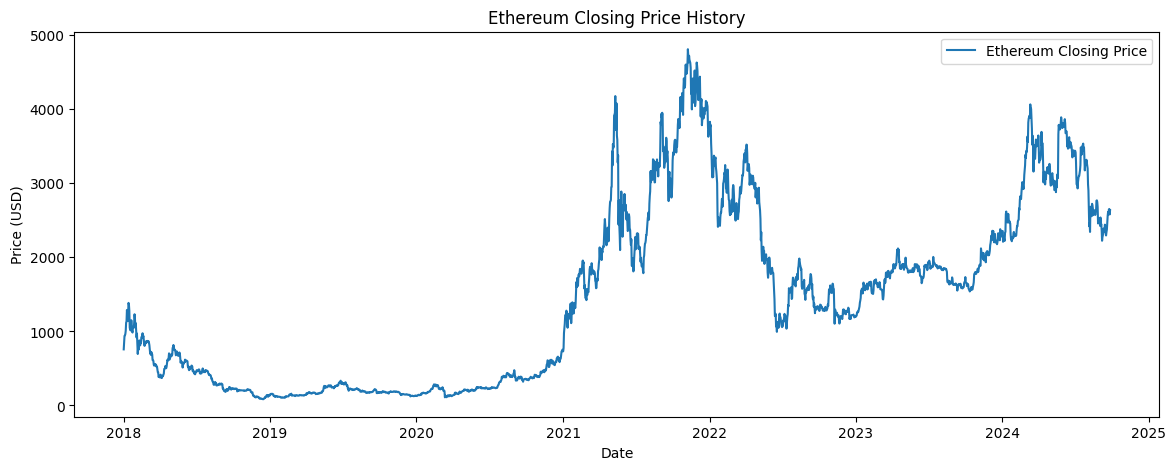

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
   units  layers  dropout  dense_units  activation  learning_rate  epochs  \
0     50       2      0.2           25        relu         0.0010      50   
1     64       3      0.3           32        tanh         0.0020     100   
2    128       2      0.1           50  leaky_relu         0.0005      70   

   batch_size optimizer     initializer  validation_loss  mean_squared_error  
0          64      adam  glorot_uniform         0.000609        15080.099022  
1          32      adam       he_normal         0.000399        27054.976255  
2         128   rmsprop       he_normal         0.000915        47751.241255  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from sklearn.metrics import mean_squared_error

# 1. Loading and Inspecting the Data
data = pd.read_csv('/content/sample_data/ethereum_daily_data_2018_2024.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Visualizing the Ethereum closing price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Ethereum Closing Price')
plt.title('Ethereum Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# 2. Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

sequence_length = 60
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# 3. Hyperparameter Tuning Experiment
experiments = []
hyperparameters = [
    {"units": 50, "layers": 2, "dropout": 0.2, "dense_units": 25, "activation": "relu",
     "learning_rate": 0.001, "epochs": 50, "batch_size": 64, "optimizer": "adam",
     "initializer": "glorot_uniform"},
    {"units": 64, "layers": 3, "dropout": 0.3, "dense_units": 32, "activation": "tanh",
     "learning_rate": 0.002, "epochs": 100, "batch_size": 32, "optimizer": "adam",
     "initializer": "he_normal"},
    {"units": 128, "layers": 2, "dropout": 0.1, "dense_units": 50, "activation": "leaky_relu",
     "learning_rate": 0.0005, "epochs": 70, "batch_size": 128, "optimizer": "rmsprop",
     "initializer": "he_normal"},
    # Add more configurations as needed
]

for config in hyperparameters:
    # Build the model
    model = Sequential()
    initializer = HeNormal() if config["initializer"] == "he_normal" else GlorotUniform()
    model.add(Input(shape=(X_train.shape[1], 1)))

    for _ in range(config["layers"]):
        model.add(LSTM(units=config["units"], return_sequences=True, kernel_initializer=initializer))
        model.add(Dropout(config["dropout"]))
    model.add(LSTM(units=config["units"], return_sequences=False, kernel_initializer=initializer))
    model.add(Dense(units=config["dense_units"], activation=config["activation"]))
    model.add(Dense(units=1, activation="linear"))

    optimizer = Adam(learning_rate=config["learning_rate"]) if config["optimizer"] == "adam" else RMSprop(learning_rate=config["learning_rate"])
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Train the model
    history = model.fit(X_train, y_train, epochs=config["epochs"], batch_size=config["batch_size"],
                        validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    val_loss = min(history.history["val_loss"])
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)),
                             scaler.inverse_transform(model.predict(X_test)))

    # Save results for comparison
    experiments.append({
        "units": config["units"],
        "layers": config["layers"],
        "dropout": config["dropout"],
        "dense_units": config["dense_units"],
        "activation": config["activation"],
        "learning_rate": config["learning_rate"],
        "epochs": config["epochs"],
        "batch_size": config["batch_size"],
        "optimizer": config["optimizer"],
        "initializer": config["initializer"],
        "validation_loss": val_loss,
        "mean_squared_error": mse
    })

# Save results to a CSV file
results_df = pd.DataFrame(experiments)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

# Display the results
print(results_df)


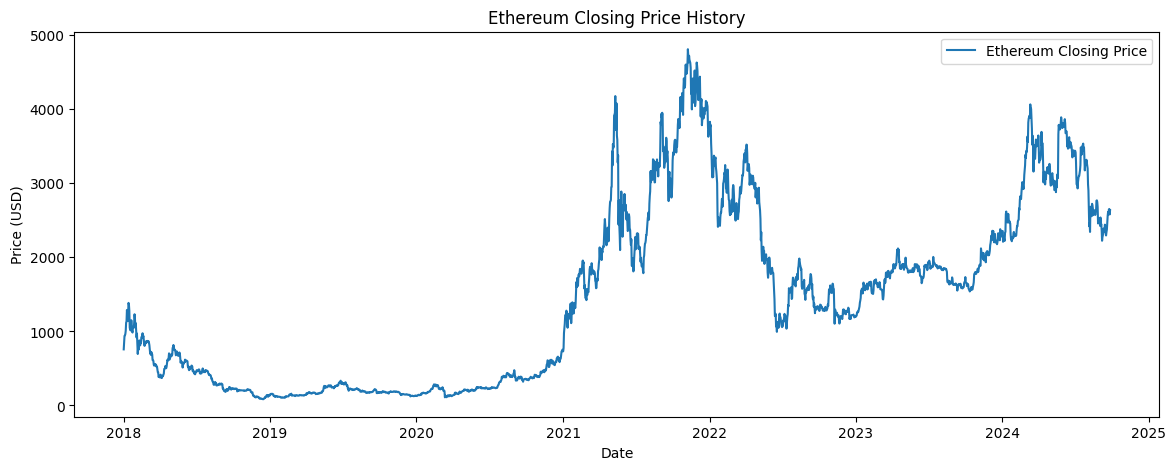

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
   units  layers  dropout  dense_units  activation  learning_rate  epochs  \
0     50       2      0.2           25        relu         0.0010      50   
1     50       2      0.2           25     sigmoid         0.0010      50   
2     64       3      0.3           32        tanh         0.0020     100   
3     64       3      0.3           32         elu         0.0020     100   
4    128       2      0.1           50  leaky_relu         0.0005      70   
5    128       2      0.1           50     softmax         0.0005      70   
6     50       2      0.2           30        relu         0.0100      50   
7     50       2     

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from sklearn.metrics import mean_squared_error

# 1. Loading and Inspecting the Data
data = pd.read_csv('/content/sample_data/ethereum_daily_data_2018_2024.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Visualizing the Ethereum closing price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Ethereum Closing Price')
plt.title('Ethereum Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# 2. Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

sequence_length = 60
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# 3. Hyperparameter Tuning Experiment
experiments = []
hyperparameters = [
    # Activation Function Variations
    {"units": 50, "layers": 2, "dropout": 0.2, "dense_units": 25, "activation": "relu",
     "learning_rate": 0.001, "epochs": 50, "batch_size": 64, "optimizer": "adam",
     "initializer": "glorot_uniform"},
    {"units": 50, "layers": 2, "dropout": 0.2, "dense_units": 25, "activation": "sigmoid",
     "learning_rate": 0.001, "epochs": 50, "batch_size": 64, "optimizer": "adam",
     "initializer": "glorot_uniform"},
    {"units": 64, "layers": 3, "dropout": 0.3, "dense_units": 32, "activation": "tanh",
     "learning_rate": 0.002, "epochs": 100, "batch_size": 32, "optimizer": "adam",
     "initializer": "he_normal"},
    {"units": 64, "layers": 3, "dropout": 0.3, "dense_units": 32, "activation": "elu",
     "learning_rate": 0.002, "epochs": 100, "batch_size": 32, "optimizer": "adam",
     "initializer": "he_normal"},
    {"units": 128, "layers": 2, "dropout": 0.1, "dense_units": 50, "activation": "leaky_relu",
     "learning_rate": 0.0005, "epochs": 70, "batch_size": 128, "optimizer": "rmsprop",
     "initializer": "he_normal"},
    {"units": 128, "layers": 2, "dropout": 0.1, "dense_units": 50, "activation": "softmax",
     "learning_rate": 0.0005, "epochs": 70, "batch_size": 128, "optimizer": "rmsprop",
     "initializer": "he_normal"},
    # Learning Rate and Optimizer Variations
    {"units": 50, "layers": 2, "dropout": 0.2, "dense_units": 30, "activation": "relu",
     "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "sgd",
     "initializer": "glorot_uniform"},
    {"units": 50, "layers": 2, "dropout": 0.3, "dense_units": 30, "activation": "sigmoid",
     "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "sgd",
     "initializer": "glorot_uniform"},
    # More Dropout Variations
    {"units": 100, "layers": 4, "dropout": 0.4, "dense_units": 50, "activation": "tanh",
     "learning_rate": 0.005, "epochs": 100, "batch_size": 32, "optimizer": "adam",
     "initializer": "he_normal"},
]

for config in hyperparameters:
    # Build the model
    model = Sequential()
    initializer = HeNormal() if config["initializer"] == "he_normal" else GlorotUniform()
    model.add(Input(shape=(X_train.shape[1], 1)))

    for _ in range(config["layers"]):
        model.add(LSTM(units=config["units"], return_sequences=True, kernel_initializer=initializer))
        model.add(Dropout(config["dropout"]))
    model.add(LSTM(units=config["units"], return_sequences=False, kernel_initializer=initializer))
    model.add(Dense(units=config["dense_units"], activation=config["activation"]))
    model.add(Dense(units=1, activation="linear"))

    if config["optimizer"] == "adam":
        optimizer = Adam(learning_rate=config["learning_rate"])
    elif config["optimizer"] == "sgd":
        optimizer = SGD(learning_rate=config["learning_rate"], momentum=0.9)
    else:
        optimizer = RMSprop(learning_rate=config["learning_rate"])

    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Train the model
    history = model.fit(X_train, y_train, epochs=config["epochs"], batch_size=config["batch_size"],
                        validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    val_loss = min(history.history["val_loss"])
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)),
                             scaler.inverse_transform(model.predict(X_test)))

    # Save results for comparison
    experiments.append({
        "units": config["units"],
        "layers": config["layers"],
        "dropout": config["dropout"],
        "dense_units": config["dense_units"],
        "activation": config["activation"],
        "learning_rate": config["learning_rate"],
        "epochs": config["epochs"],
        "batch_size": config["batch_size"],
        "optimizer": config["optimizer"],
        "initializer": config["initializer"],
        "validation_loss": val_loss,
        "mean_squared_error": mse
    })

# Save results to a CSV file
results_df = pd.DataFrame(experiments)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

# Display the results
print(results_df)
